# REB Resource Recommendation Model

This notebook implements a recommendation model that suggests REB e-learning resources    
based on assignment descriptions.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import spacy
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

### 1. Data Visualization & Engineering

The dataset contains REB e-learning resources categorized by grade level and subject.     
We analyze the distribution of subjects and visualize common keywords.

### Sample dataset of REB resources

-- Narrowing the scope to the Nursery students only for the pilot project.

In [39]:
# Sample dataset of REB resources
reb_resources = pd.DataFrame({
    'Grade Level': [
        'Nursery 1',
        'Nursery 1',
        'Nursery 1',
        'Nursery 1',
        'Nursery 2',
        'Nursery 2',
        'Nursery 2',
        'Nursery 2',
        'Nursery 3',
        'Nursery 3',
        'Nursery 3',
        'Nursery 3',
        'Primary 1', 
        'Primary 2', 
        'Primary 3'
    ],
    'Subject': [
        'Math',
        'Animals',
        'Me and my family',
        'Art and culture',
        'Math',
        'Wild Animals',
        'Me and my family',
        'Art and culture',
        'Math',
        'Domesticated Animals',
        'Me and my family',
        'Art and culture',
        'Math',
        'Science',
        'English'
    ],
    'Topic Keywords': [
        'matching, filling the missing, circling, canceling out',
        'cow, hen. goat, milk, animals, roles, animals',
        'my name, age, mother, father, old, parts of my body, house, home, bride, bridegroom, birthday, naming',
        'filling based on the example, drawing based on the example, based on the example, joining the point, repeat, draw',
        'bigger, smaller, order, taller, shorter, matching colors, lighter, heavier, under, front, behind, at the top, square, triangle,circles, counting from 1 to 10, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10',
        'naming big animals, naming different type of birds, name different type of flies, wild animas',
        'rough, smooth, hot, cold, television, radio, smell, taste, sense, father mother grandmother grandfather, big sister ,big brother, small siste, small brother, naming clothes, matching what matches',
        'filling based on the example, drawing based on the example, based on the example, joining the point, repeat, draw',
        'bigger, smaller, order, taller, shorter, matching colors, lighter, heavier, under, front, behind, at the top, square, triangle,circles, counting from 1 to 10, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, counting 20',
        'Domesticated animals, pigs, eggs, milk, mouse, sheeps',
        'rough, smooth, hot, cold, television, radio, smell, taste, sense, father mother grandmother grandfather, big sister ,big brother, small siste, small brother, naming clothes, matching what matches',
        'filling based on the example, drawing based on the example, based on the example, joining the point, repeat, draw',
        'Addition, Subtraction, multiplicatin division',
        'Plants, Animals, water, air', 
        'Grammar, Vocabulary'
    ],
    'URL': [
        'https://elearning.reb.rw/course/view.php?id=219',
        'https://elearning.reb.rw/course/view.php?id=718',
        'https://elearning.reb.rw/course/view.php?id=719',
        'https://elearning.reb.rw/course/view.php?id=720',
        'https://elearning.reb.rw/course/view.php?id=735',
        'https://elearning.reb.rw/course/view.php?id=228',
        'https://elearning.reb.rw/course/view.php?id=728',
        'https://elearning.reb.rw/course/view.php?id=736',
        'https://elearning.reb.rw/course/view.php?id=748',
        'https://elearning.reb.rw/course/view.php?id=232',
        'https://elearning.reb.rw/course/view.php?id=728',
        'https://elearning.reb.rw/course/view.php?id=749',
        'https://elearning.reb.rw/pluginfile.php/45472/mod_resource/content/2/MATH%20P1.pdf',
        'https://elearning.reb.rw/pluginfile.php/85767/mod_resource/content/1/SET%20P2%20Student%20Book.pdf',
        'https://elearning.reb.rw/pluginfile.php/45481/mod_resource/content/1/English%20p3.pdf'
    ]
})

reb_resources.head(10)

,Grade Level,Subject,Topic Keywords,URL
0,Nursery 1,Math,"matching, filling the missing, circling, cance...",https://elearning.reb.rw/course/view.php?id=219
1,Nursery 1,Animals,"cow, hen. goat, milk, animals, roles, animals",https://elearning.reb.rw/course/view.php?id=718
2,Nursery 1,Me and my family,"my name, age, mother, father, old, parts of my...",https://elearning.reb.rw/course/view.php?id=719
3,Nursery 1,Art and culture,"filling based on the example, drawing based on...",https://elearning.reb.rw/course/view.php?id=720
4,Nursery 2,Math,"bigger, smaller, order, taller, shorter, match...",https://elearning.reb.rw/course/view.php?id=735
5,Nursery 2,Wild Animals,"naming big animals, naming different type of b...",https://elearning.reb.rw/course/view.php?id=228
6,Nursery 2,Me and my family,"rough, smooth, hot, cold, television, radio, s...",https://elearning.reb.rw/course/view.php?id=728
7,Nursery 2,Art and culture,"filling based on the example, drawing based on...",https://elearning.reb.rw/course/view.php?id=736
8,Nursery 3,Math,"bigger, smaller, order, taller, shorter, match...",https://elearning.reb.rw/course/view.php?id=748
9,Nursery 3,Domesticated Animals,"Domesticated animals, pigs, eggs, milk, mouse,...",https://elearning.reb.rw/course/view.php?id=232


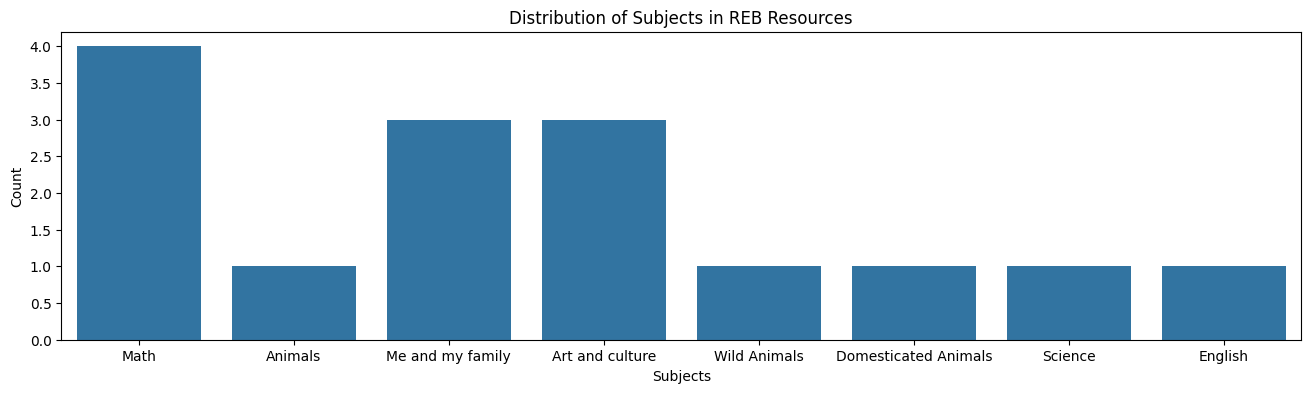

In [40]:
# Visualizing the distribution of subjects
plt.figure(figsize=(16,4))
sns.countplot(x='Subject', data=reb_resources)
plt.title("Distribution of Subjects in REB Resources")
plt.xlabel("Subjects")
plt.ylabel("Count")
plt.show()

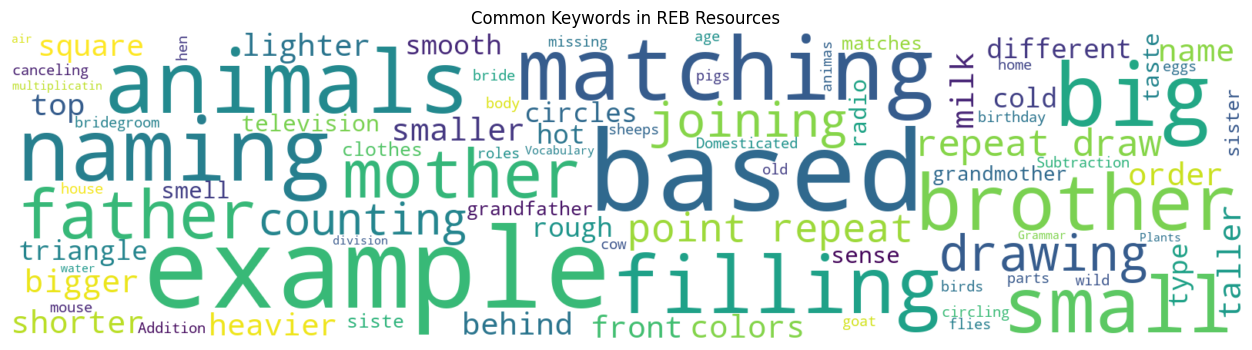

In [41]:
# Creating a word cloud of topic keywords
all_keywords = ' '.join(reb_resources['Topic Keywords'])
wordcloud = WordCloud(width=1600, height=400, background_color='white').generate(all_keywords)

plt.figure(figsize=(16,4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Common Keywords in REB Resources")
plt.show()

In [42]:
# Load spaCy model
nlp = spacy.load("en_core_web_sm")

### 2. Model Architecture

The recommendation model follows these steps:
- **Text Preprocessing**: Tokenization, Lemmatization, Stop-word Removal
- **Feature Extraction**: TF-IDF Vectorization to convert text into numerical form
- **Similarity Computation**: Cosine Similarity to match assignments with REB resources
- **Resource Recommendation**: Select the most relevant resource based on highest similarity score


In [43]:
# Convert topic keywords into a single text column
reb_resources['Combined Text'] = reb_resources[['Grade Level', 'Subject', 'Topic Keywords']].agg(' '.join, axis=1)

In [44]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer()
resource_vectors = vectorizer.fit_transform(reb_resources['Combined Text'])

### 3. Recommendation System Implementation

The function `get_recommendation` takes an assignment description, extracts keywords,     
and finds the most relevant REB resource using cosine similarity.

In [46]:
def get_recommendation(assignment_desc):
    """Recommend REB e-learning resource based on assignment description."""
    # Preprocess assignment text
    assignment_doc = nlp(assignment_desc.lower())
    keywords = ' '.join([token.lemma_ for token in assignment_doc if not token.is_stop])
    
    # Convert to TF-IDF vector
    assignment_vector = vectorizer.transform([keywords])
    
    # Compute similarity
    similarities = cosine_similarity(assignment_vector, resource_vectors)
    
    # Get the best match
    best_match_idx = np.argmax(similarities)
    best_resource = reb_resources.iloc[best_match_idx]
    
    return best_resource['URL']

In [48]:
# Example Usage
assignment_text = "Name the following wild animals"
recommended_url = get_recommendation(assignment_text)
print("Recommended REB Resource:", recommended_url)


Recommended REB Resource: https://elearning.reb.rw/course/view.php?id=228


### 4. Model Performance Evaluation

To measure the model's accuracy, we test it with sample assignments and compare the predicted vs actual resource.

In [49]:
# Sample test dataset
test_assignments = [
    ("Solve 5+3 and 7-2.", 'https://elearning.reb.rw/pluginfile.php/45472/mod_resource/content/2/MATH%20P1.pdf'),
    ("Learn about different types of animals.", 'https://elearning.reb.rw/pluginfile.php/85767/mod_resource/content/1/SET%20P2%20Student%20Book.pdf'),
    ("Improve vocabulary and sentence structure.", 'https://elearning.reb.rw/pluginfile.php/45481/mod_resource/content/1/English%20p3.pdf')
]

In [51]:
# Evaluate performance
correct_predictions = 0
total_similarity = 0
num_samples = len(test_assignments)

for text, expected_url in test_assignments:
    recommended_url = get_recommendation(text)
    print(f"Assignment: {text}\nExpected: {expected_url}\nPredicted: {recommended_url}\n")
    
    # Check if the top recommended URL is correct
    if recommended_url == expected_url:
        correct_predictions += 1

# Compute accuracy
accuracy = correct_predictions / num_samples
print(f"Top-1 Accuracy: {accuracy:.2%}")

Assignment: Solve 5+3 and 7-2.
Expected: https://elearning.reb.rw/pluginfile.php/45472/mod_resource/content/2/MATH%20P1.pdf
Predicted: https://elearning.reb.rw/course/view.php?id=219

Assignment: Learn about different types of animals.
Expected: https://elearning.reb.rw/pluginfile.php/85767/mod_resource/content/1/SET%20P2%20Student%20Book.pdf
Predicted: https://elearning.reb.rw/course/view.php?id=228

Assignment: Improve vocabulary and sentence structure.
Expected: https://elearning.reb.rw/pluginfile.php/45481/mod_resource/content/1/English%20p3.pdf
Predicted: https://elearning.reb.rw/pluginfile.php/45481/mod_resource/content/1/English%20p3.pdf

Top-1 Accuracy: 33.33%


### 